## Capstone Project - Diamond Prices (Part 1 - Round Only)

In [188]:
#I was able to get a large dataset of diamond prices from recent years (2017+) through a contact at a diamond aggregator company
#It has more features than the public datasets I looked at on Kaggle
#In addition, it has a robust amount of data for fancy shapes (non-round), while the Kaggle dataset was only for round diamonds
#I will split my model into round and non-round to reflect industry pricing standards (Rapaport guide)
#Example of Rapaport pricing guide: https://www.diamonds.net/Prices/RapaportPriceGuide.aspx

In [243]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.datasets import fetch_openml
from sklearn import svm
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt
import pickle
import xgboost
from xgboost import XGBClassifier
import plotly as py
import plotly.graph_objs as go
import seaborn as sns

In [190]:
df = pd.read_csv('../assets/Diamond Capstone Round Only.csv')
df.head()

,shape,carat,cut,color,clarity,price,certificateLab,certificateID,depth_pct,table_width_pct,polish,symmetry,fluorescence,crownAngle,crownHeight,pavilionAngle,pavilionDepth,measurements
0,Round,3.01,Very Good,D,VS2,96980.26,GIA,16834315,62.6,57.0,Very Good ...,Excellent ...,None,36.5,16.0,40.4,42.5,9.15x9.08x5.71
1,Round,1.26,Excellent,I,SI1,7722.58,GIA,5106816542,62.2,55.0,Excellent ...,Excellent ...,None,34.5,15.5,41.2,43.5,6.98x6.94x4.33
2,Round,4.03,Very Good,E,VS1,239200.00,GIA,17154415,62.2,56.0,Excellent ...,Very Good ...,None,35.0,16.0,40.6,43.0,10.21x10.08x6.31
3,Round,1.86,Excellent,E,VS2,27508.00,GIA,2121115822,62.5,57.0,Excellent ...,Excellent ...,None,35.5,15.5,41.0,43.5,7.85x7.80x4.89
4,Round,4.28,Very Good,H,SI1,84081.29,GIA,16291982,61.3,56.0,Excellent ...,Very Good ...,None,36.0,16.5,40.2,42.0,10.49x10.41x6.41


## Exploratory Data Analysis

In [191]:
df.shape
#>100K records
#18 features! more than the public dataset I worked with previously

(111469, 18)

In [192]:
#check for missing data
df.isnull().sum()
#some missing data, but pretty small compared to the number of records (<1%) so I will drop them rather than trying to fill them in

shape                0
carat                0
cut                  0
color              539
clarity              0
price                0
certificateLab       0
certificateID        0
depth_pct            0
table_width_pct      0
polish              33
symmetry           260
fluorescence       273
crownAngle           0
crownHeight          0
pavilionAngle        0
pavilionDepth        0
measurements         0
dtype: int64

In [193]:
#drop the records that are missing color
print(df['color'].value_counts(dropna = False))
df.dropna(subset=['color'], inplace=True)
print(df['color'].value_counts(dropna=False))

E      17584
D      17235
F      16998
G      16694
H      14529
I      11219
J       7347
K       4530
L       2520
M       2255
NaN      539
N         11
OP         4
UV         2
QR         1
XY         1
Name: color, dtype: int64
E     17584
D     17235
F     16998
G     16694
H     14529
I     11219
J      7347
K      4530
L      2520
M      2255
N        11
OP        4
UV        2
QR        1
XY        1
Name: color, dtype: int64


In [194]:
df.isnull().sum()

shape                0
carat                0
cut                  0
color                0
clarity              0
price                0
certificateLab       0
certificateID        0
depth_pct            0
table_width_pct      0
polish              29
symmetry           252
fluorescence       208
crownAngle           0
crownHeight          0
pavilionAngle        0
pavilionDepth        0
measurements         0
dtype: int64

In [195]:
#check what the possible values are for polish, symmetry, and flourescence

In [196]:
print(df['fluorescence'].value_counts(dropna=False))

None                78987
Faint               15107
Medium               9501
Strong               5146
Very Slight           848
Slight                482
Very Strong           437
NaN                   208
Medium Blue           111
Strong Blue            83
Very Strong Blue       19
Medium White            1
Name: fluorescence, dtype: int64


In [197]:
print(df['symmetry'].value_counts(dropna=False))

Excellent                                             72185
Very Good                                             25844
Good                                                   6475
Excellent                                              2304
Very Good                                              1789
Fair                                                    856
Good                                                    800
Ideal                                                   406
NaN                                                     252
Ideal                                                     9
Fair                                                      7
Poor                                                      3
Name: symmetry, dtype: int64


In [198]:
print(df['polish'].value_counts(dropna=False))

Excellent                                             84671
Very Good                                             17445
Excellent                                              3874
Good                                                   3326
Very Good                                              1062
Ideal                                                   425
Fair                                                     70
NaN                                                      29
Good                                                     19
Ideal                                                     9
Name: polish, dtype: int64


In [199]:
#looks like the vast majority of the data for polish, symmetry and fluorescence are the same, so I can probably just set null values to 
#but since the missing data is small I'll just drop them

In [200]:
df.dropna(subset=['fluorescence'], inplace=True)
df.dropna(subset=['symmetry'], inplace=True)
df.dropna(subset=['polish'], inplace=True)

In [201]:
df.shape
#down to 110K records vs. original dataset of 111K (99%)

(110475, 18)

In [202]:
#take a look at the datatypes
df.dtypes

shape               object
carat              float64
cut                 object
color               object
clarity             object
price              float64
certificateLab      object
certificateID       object
depth_pct          float64
table_width_pct    float64
polish              object
symmetry            object
fluorescence        object
crownAngle         float64
crownHeight        float64
pavilionAngle      float64
pavilionDepth      float64
measurements        object
dtype: object

In [203]:
#double check that I only have round diamonds in this analysis
df['shape'].value_counts()

Round    110475
Name: shape, dtype: int64

In [204]:
#other observations from the data types:
#For linear regression, I will need to re-code cut, color, and clarity since they are non-numerical
#I will also re-code certificateLab
#For polish, symmetry and flourescence I will likely have to group values before re-coding since there are a lot of possible values
#I will not use certificateid since it is just an identifier
#I will likely not need measurements either since it probably correlated with other features

## Re-code Non-Numerical Features

In [205]:
df['color'].value_counts()
#usually color only goes up to M? I will drop the others; not sure what OP, UV and XY are

E     17527
D     17168
F     16934
G     16622
H     14486
I     11144
J      7308
K      4508
L      2510
M      2252
N         9
OP        4
UV        2
XY        1
Name: color, dtype: int64

In [206]:
print(df['color'].value_counts())
df = df.drop(df[df["color"]=='N'].index)
df = df.drop(df[df["color"]=='OP'].index)
df = df.drop(df[df["color"]=='UV'].index)
df = df.drop(df[df["color"]=='XY'].index)
print(df['color'].value_counts())

E     17527
D     17168
F     16934
G     16622
H     14486
I     11144
J      7308
K      4508
L      2510
M      2252
N         9
OP        4
UV        2
XY        1
Name: color, dtype: int64
E    17527
D    17168
F    16934
G    16622
H    14486
I    11144
J     7308
K     4508
L     2510
M     2252
Name: color, dtype: int64


In [207]:
#re-code the remaining colors to numerical
print(df['color'].value_counts())
df['color'] = df['color'].map({"D":1, "E": 2, "F":3, "G":4, "H":5, "I":6, "J":7, "K":8, "L":9, "M":10})
print(df['color'].value_counts())

E    17527
D    17168
F    16934
G    16622
H    14486
I    11144
J     7308
K     4508
L     2510
M     2252
Name: color, dtype: int64
2     17527
1     17168
3     16934
4     16622
5     14486
6     11144
7      7308
8      4508
9      2510
10     2252
Name: color, dtype: int64


In [208]:
df.shape

(110459, 18)

In [209]:
df['clarity'].value_counts()
#one has a clarity of none but the rest look fine; drop that one record

VS1     19006
VS2     18219
VVS2    16655
SI1     15973
VVS1    15666
SI2     13521
IF       7601
I1       3496
FL        321
None        1
Name: clarity, dtype: int64

In [210]:
print(df['clarity'].value_counts())
df = df.drop(df[df["clarity"]=='None'].index)
print(df['clarity'].value_counts())

VS1     19006
VS2     18219
VVS2    16655
SI1     15973
VVS1    15666
SI2     13521
IF       7601
I1       3496
FL        321
None        1
Name: clarity, dtype: int64
VS1     19006
VS2     18219
VVS2    16655
SI1     15973
VVS1    15666
SI2     13521
IF       7601
I1       3496
FL        321
Name: clarity, dtype: int64


In [211]:
#re-code the remaining clarity to numerical
print(df['clarity'].value_counts())
df['clarity'] = df['clarity'].map({"FL":1, "IF": 2, "VVS1":3, "VVS2":4, "VS1":5, "VS2":6, "SI1":7, "SI2":8, "I1":9})
print(df['clarity'].value_counts())
#based on the gia guide: https://4cs.gia.edu/en-us/diamond-clarity/

VS1     19006
VS2     18219
VVS2    16655
SI1     15973
VVS1    15666
SI2     13521
IF       7601
I1       3496
FL        321
Name: clarity, dtype: int64
5    19006
6    18219
4    16655
7    15973
3    15666
8    13521
2     7601
9     3496
1      321
Name: clarity, dtype: int64


In [212]:
df.shape

(110458, 18)

In [213]:
df['cut'].value_counts()
#looks normal

Excellent    75242
Very Good    23363
Good          9650
Fair          1824
Ideal          379
Name: cut, dtype: int64

In [214]:
print(df['cut'].value_counts())
df['cut'] = df['cut'].map({"Ideal":1, "Excellent": 2, "Very Good":3, "Good":4, "Fair":5})
print(df['cut'].value_counts())

Excellent    75242
Very Good    23363
Good          9650
Fair          1824
Ideal          379
Name: cut, dtype: int64
2    75242
3    23363
4     9650
5     1824
1      379
Name: cut, dtype: int64


In [215]:
df['certificateLab'].value_counts()
#vast majority are GIA
#the only other one I've seen is IGI
#group the others

GIA    101373
IGI      7798
HRD       731
AGS       554
B2C         2
Name: certificateLab, dtype: int64

In [216]:
print(df['certificateLab'].value_counts())
df['certificateLab'] = df['certificateLab'].map({"GIA":"GIA", "IGI":"IGI", "HRD":"Other", "AGS":"Other", "B2C":"Other"})
print(df['certificateLab'].value_counts())
#probably not the most efficient way to rename these, but wanted to keep the logic consistent with the rest of the re-coding

GIA    101373
IGI      7798
HRD       731
AGS       554
B2C         2
Name: certificateLab, dtype: int64
GIA      101373
IGI        7798
Other      1287
Name: certificateLab, dtype: int64


In [217]:
#now I will get dummies to turn these into numericals
ohe=pd.get_dummies(df['certificateLab'])
print(ohe.columns)
ohe.head()

Index(['GIA', 'IGI', 'Other'], dtype='object')


,GIA,IGI,Other
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [218]:
# append these new columns to the original dataset
df=pd.concat([df, ohe], axis=1) #append columns, not rows
df.shape
#3 extra columns now

(110458, 21)

In [219]:
df.head()

,shape,carat,cut,color,clarity,price,certificateLab,certificateID,depth_pct,table_width_pct,...,symmetry,fluorescence,crownAngle,crownHeight,pavilionAngle,pavilionDepth,measurements,GIA,IGI,Other
0,Round,3.01,3,1,6,96980.26,GIA,16834315,62.6,57.0,...,Excellent ...,None,36.5,16.0,40.4,42.5,9.15x9.08x5.71,1,0,0
1,Round,1.26,2,6,7,7722.58,GIA,5106816542,62.2,55.0,...,Excellent ...,None,34.5,15.5,41.2,43.5,6.98x6.94x4.33,1,0,0
2,Round,4.03,3,2,5,239200.00,GIA,17154415,62.2,56.0,...,Very Good ...,None,35.0,16.0,40.6,43.0,10.21x10.08x6.31,1,0,0
3,Round,1.86,2,2,6,27508.00,GIA,2121115822,62.5,57.0,...,Excellent ...,None,35.5,15.5,41.0,43.5,7.85x7.80x4.89,1,0,0
4,Round,4.28,3,5,7,84081.29,GIA,16291982,61.3,56.0,...,Very Good ...,None,36.0,16.5,40.2,42.0,10.49x10.41x6.41,1,0,0


In [220]:
df.shape

(110458, 21)

In [221]:
#remove the original column that we replaced with one-hot encoding
df=df.drop(['certificateLab'], axis=1).copy()
df.head()

,shape,carat,cut,color,clarity,price,certificateID,depth_pct,table_width_pct,polish,symmetry,fluorescence,crownAngle,crownHeight,pavilionAngle,pavilionDepth,measurements,GIA,IGI,Other
0,Round,3.01,3,1,6,96980.26,16834315,62.6,57.0,Very Good ...,Excellent ...,None,36.5,16.0,40.4,42.5,9.15x9.08x5.71,1,0,0
1,Round,1.26,2,6,7,7722.58,5106816542,62.2,55.0,Excellent ...,Excellent ...,None,34.5,15.5,41.2,43.5,6.98x6.94x4.33,1,0,0
2,Round,4.03,3,2,5,239200.00,17154415,62.2,56.0,Excellent ...,Very Good ...,None,35.0,16.0,40.6,43.0,10.21x10.08x6.31,1,0,0
3,Round,1.86,2,2,6,27508.00,2121115822,62.5,57.0,Excellent ...,Excellent ...,None,35.5,15.5,41.0,43.5,7.85x7.80x4.89,1,0,0
4,Round,4.28,3,5,7,84081.29,16291982,61.3,56.0,Excellent ...,Very Good ...,None,36.0,16.5,40.2,42.0,10.49x10.41x6.41,1,0,0


In [222]:
df.shape

(110458, 20)

In [223]:
df['polish'].value_counts()
#similar to how cut is classified
#seeing some duplicates so will need to investigate and clean that up

Excellent                                             84379
Very Good                                             17326
Excellent                                              3874
Good                                                   3299
Very Good                                              1062
Ideal                                                   421
Fair                                                     69
Good                                                     19
Ideal                                                     9
Name: polish, dtype: int64

In [224]:
df[df["polish"]=='Excellent'].shape

(3874, 20)

In [225]:
#used a quick pivot table in excel to find the issue; a lot of spaces at the end of the labels
df['polish'] = df['polish'].str.strip()

In [226]:
df['polish'].value_counts()
#now it looks clean

Excellent    88253
Very Good    18388
Good          3318
Ideal          430
Fair            69
Name: polish, dtype: int64

In [227]:
print(df['polish'].value_counts())
df['polish'] = df['polish'].map({"Ideal":1, "Excellent": 2, "Very Good":3, "Good":4, "Fair":5})
print(df['polish'].value_counts())

Excellent    88253
Very Good    18388
Good          3318
Ideal          430
Fair            69
Name: polish, dtype: int64
2    88253
3    18388
4     3318
1      430
5       69
Name: polish, dtype: int64


In [228]:
df['symmetry'].value_counts()
#looks like the same issue as above

Excellent                                             72079
Very Good                                             25773
Good                                                   6444
Excellent                                              2304
Very Good                                              1789
Fair                                                    848
Good                                                    800
Ideal                                                   402
Ideal                                                     9
Fair                                                      7
Poor                                                      3
Name: symmetry, dtype: int64

In [229]:
df['symmetry'] = df['symmetry'].str.strip()

In [230]:
df['symmetry'].value_counts()
#now it looks clean

Excellent    74383
Very Good    27562
Good          7244
Fair           855
Ideal          411
Poor             3
Name: symmetry, dtype: int64

In [231]:
print(df['symmetry'].value_counts())
df['symmetry'] = df['symmetry'].map({"Ideal":1, "Excellent": 2, "Very Good":3, "Good":4, "Fair":5, "Poor":6})
print(df['symmetry'].value_counts())

Excellent    74383
Very Good    27562
Good          7244
Fair           855
Ideal          411
Poor             3
Name: symmetry, dtype: int64
2    74383
3    27562
4     7244
5      855
1      411
6        3
Name: symmetry, dtype: int64


In [232]:
df['fluorescence'].value_counts()
#GIA only grades fluorescence as "None, Faint, Medium, Strong, Very Strong"; not sure how to group the other ones
#It also seems like this is not a very important factor for purchasers so I will exclude from my model for now

None                78782
Faint               15078
Medium               9488
Strong               5136
Very Slight           843
Slight                480
Very Strong           437
Medium Blue           111
Strong Blue            83
Very Strong Blue       19
Medium White            1
Name: fluorescence, dtype: int64

In [233]:
df.shape

(110458, 20)

In [234]:
df.dtypes

shape               object
carat              float64
cut                  int64
color                int64
clarity              int64
price              float64
certificateID       object
depth_pct          float64
table_width_pct    float64
polish               int64
symmetry             int64
fluorescence        object
crownAngle         float64
crownHeight        float64
pavilionAngle      float64
pavilionDepth      float64
measurements        object
GIA                  uint8
IGI                  uint8
Other                uint8
dtype: object

## Modeling the Price

In [235]:
#now that the non-numerical data has been recoded, check correlations to see which features are most important
corrs = df.corr()
corrs

,carat,cut,color,clarity,price,depth_pct,table_width_pct,polish,symmetry,crownAngle,crownHeight,pavilionAngle,pavilionDepth,GIA,IGI,Other
carat,1.000000,-0.050591,0.171670,0.132576,0.637117,-0.010548,0.007491,-0.060851,-0.062518,-0.081628,0.068631,-0.089084,0.068405,-0.056137,0.018278,0.100094
cut,-0.050591,1.000000,0.089870,0.160564,-0.045399,0.372406,0.127114,0.477362,0.680819,-0.031207,0.071119,-0.095261,0.077172,-0.011728,0.030142,-0.041922
color,0.171670,0.089870,1.000000,0.121075,-0.003480,0.050699,0.000287,0.042824,0.062533,-0.044856,-0.011096,-0.102827,-0.011259,-0.150830,0.151462,0.024625
clarity,0.132576,0.160564,0.121075,1.000000,-0.017231,0.051504,0.003100,0.176263,0.145407,-0.066286,0.036141,-0.140621,0.034632,-0.051956,0.037043,0.044599
price,0.637117,-0.045399,-0.003480,-0.017231,1.000000,-0.027171,0.005490,-0.036267,-0.044734,-0.020073,0.027495,-0.021929,0.027763,-0.011505,-0.005593,0.042807
depth_pct,-0.010548,0.372406,0.050699,0.051504,-0.027171,1.000000,-0.114810,0.013411,0.179377,0.054551,-0.030638,0.031811,-0.045749,-0.067454,0.078489,-0.014654
table_width_pct,0.007491,0.127114,0.000287,0.003100,0.005490,-0.114810,1.000000,0.165804,0.141389,-0.038417,0.021449,-0.027021,0.042893,0.077624,-0.076569,-0.015969
polish,-0.060851,0.477362,0.042824,0.176263,-0.036267,0.013411,0.165804,1.000000,0.555279,-0.072541,0.123392,-0.113207,0.132774,0.064203,-0.038421,-0.072665
symmetry,-0.062518,0.680819,0.062533,0.145407,-0.044734,0.179377,0.141389,0.555279,1.000000,-0.029883,0.087139,-0.084706,0.096814,-0.025881,0.057681,-0.071421
crownAngle,-0.081628,-0.031207,-0.044856,-0.066286,-0.020073,0.054551,-0.038417,-0.072541,-0.029883,1.000000,-0.060690,0.741977,-0.065333,-0.022768,0.022330,0.004989


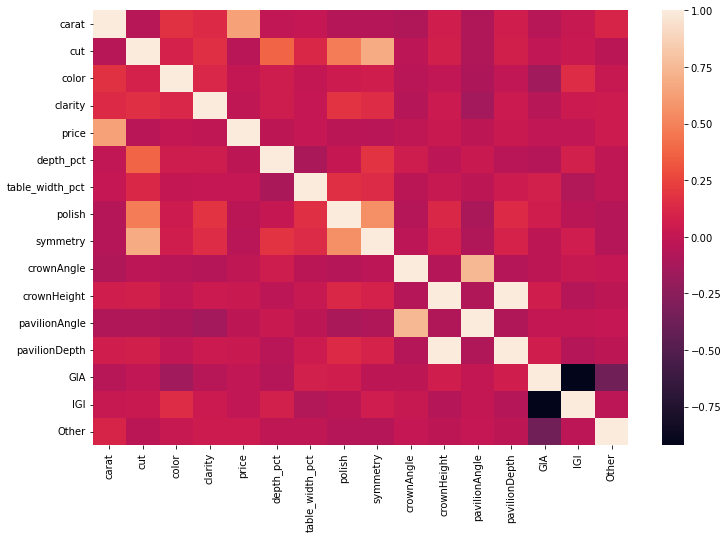

In [236]:
#heatmap to see the correlations more clearly
plt.figure(figsize=(12,8))
sns.heatmap(corrs);

In [237]:
corrs['price'].sort_values()
#similar to my last diamond price analysis; not seeing anything with strong correlation to price besides "carat". 

cut               -0.045399
symmetry          -0.044734
polish            -0.036267
depth_pct         -0.027171
pavilionAngle     -0.021929
crownAngle        -0.020073
clarity           -0.017231
GIA               -0.011505
IGI               -0.005593
color             -0.003480
table_width_pct    0.005490
crownHeight        0.027495
pavilionDepth      0.027763
Other              0.042807
carat              0.637117
price              1.000000
Name: price, dtype: float64

In [264]:
#take a quick look ta the target variable
df.describe()
#the scale of price is weird?

,carat,cut,color,clarity,price,depth_pct,table_width_pct,polish,symmetry,crownAngle,crownHeight,pavilionAngle,pavilionDepth,GIA,IGI,Other
count,110458.000000,110458.000000,110458.000000,110458.000000,1.104580e+05,110458.000000,110458.000000,110458.000000,110458.000000,110458.000000,110458.000000,110458.000000,110458.000000,110458.000000,110458.000000,110458.000000
mean,0.835177,2.432345,3.993636,5.295479,5.948045e+03,62.179623,57.959398,2.224529,2.400297,22.540216,0.734238,27.095983,2.221817,0.917752,0.070597,0.011651
std,0.793164,0.725324,2.296074,1.909995,3.049067e+04,2.252075,2.438332,0.495710,0.652255,19.660037,3.182180,19.616273,9.573749,0.274744,0.256152,0.107312
min,0.140000,1.000000,1.000000,1.000000,1.447800e+02,0.500000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,2.000000,2.000000,4.000000,7.499050e+02,61.200000,57.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,0.600000,2.000000,4.000000,5.000000,1.660575e+03,62.200000,58.000000,2.000000,2.000000,33.500000,0.000000,40.800000,0.000000,1.000000,0.000000,0.000000
75%,1.010000,3.000000,6.000000,7.000000,4.798540e+03,62.900000,59.000000,2.000000,3.000000,35.500000,0.000000,41.200000,0.000000,1.000000,0.000000,0.000000
max,25.250000,5.000000,10.000000,9.000000,3.777064e+06,79.800000,90.000000,5.000000,6.000000,3605.000000,20.000000,69.800000,48.500000,1.000000,1.000000,1.000000


In [267]:
#make a copy of the data with only the features I will model
df= df[['price', 'carat', 'cut', 'clarity', 'color', 'Other', 'IGI', 'GIA', 'polish', 'symmetry']].copy()
df.head()

,price,carat,cut,clarity,color,Other,IGI,GIA,polish,symmetry
0,96980.26,3.01,3,6,1,0,0,1,3,2
1,7722.58,1.26,2,7,6,0,0,1,2,2
2,239200.00,4.03,3,5,2,0,0,1,2,3
3,27508.00,1.86,2,6,2,0,0,1,2,2
4,84081.29,4.28,3,7,5,0,0,1,2,3


In [268]:
#declare the target variable
y = df['price']
y.shape

(110458,)

In [269]:
#declare the model features
X = df.drop(['price'], axis=1) #just exclude price
X.shape

(110458, 9)

In [289]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state=12) #using the standard test size for now

In [290]:
#instantiate the SKlearn algorithm
mymodel = LinearRegression(fit_intercept=True, 
                           normalize=False, 
                           copy_X=True, 
                           n_jobs=None, 
                           positive=False)

In [291]:
#fit the model to the training dataset
mymodel.fit(X_train, y_train)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning:

'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.



LinearRegression(normalize=False)

In [292]:
print(mymodel)

LinearRegression(normalize=False)


In [293]:
#what is the intercept?
mymodel.intercept_
#according to my model intercept, if carat, cut, clarity, color, polish, symmetry and the rating agencies were all 0, the diamond would be priced at -$6K
#doesn't really tell us much since that wouldn't happen in the real world

-6223.282503754364

In [294]:
#what is the equation for this mymodel?
cols=list(X.columns)
coefs=list(mymodel.coef_)
xcoefs = [(coefs[i], cols[i]) for i in range(0, len(cols))]
output = f'y = {round(mymodel.intercept_,2)} + {round(xcoefs[0][0],2)}*{xcoefs[0][1]} + {round(xcoefs[1][0],2)}*{xcoefs[1][1]} + {round(xcoefs[2][0],2)}*{xcoefs[2][1]} + {round(xcoefs[3][0],2)}*{xcoefs[3][1]} + {round(xcoefs[4][0],2)}*{xcoefs[4][1]} + {round(xcoefs[5][0],2)}*{xcoefs[5][1]} + {round(xcoefs[6][0],2)}*{xcoefs[6][1]}+ {round(xcoefs[7][0],2)}*{xcoefs[7][1]}+ {round(xcoefs[8][0],2)}*{xcoefs[8][1]}'
print("Regression Equation: ", output)
#cut, clarity, and color all have negative intercepts because I mapped the "best" to 1 with ascending values after that so that makes sense

Regression Equation:  y = -6223.28 + 25688.87*carat + -42.65*cut + -1551.34*clarity + -1452.4*color + -2764.06*Other + 1531.52*IGI + 1232.54*GIA+ 1460.12*polish+ 159.93*symmetry


In [295]:
#for the graph below
coefs=list(mymodel.coef_)
cols=list(X.columns)

In [296]:
#turn these into a dataframe
results = pd.DataFrame(list(zip(cols, coefs)), columns=['feature','coeff'])
results 

,feature,coeff
0,carat,25688.872576
1,cut,-42.645817
2,clarity,-1551.339669
3,color,-1452.400344
4,Other,-2764.059526
5,IGI,1531.521900
6,GIA,1232.537625
7,polish,1460.123291
8,symmetry,159.929342


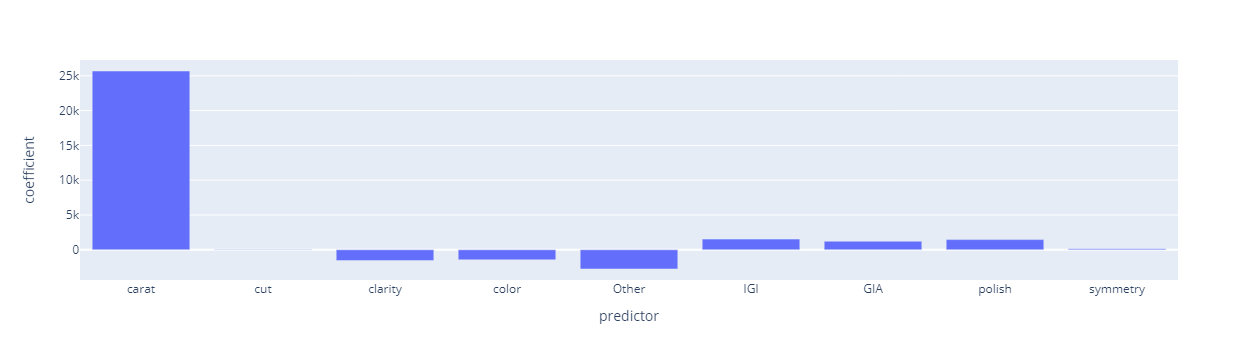

In [297]:
#show results as a bar chart
import plotly.express as px
fig = px.bar(x=results['feature'], y=results['coeff'])
fig.update_layout(
    yaxis=dict( title='coefficient'),
    xaxis=dict( title='predictor'),
)
fig.show()
#surprisingly, cut doesn't seem to have much of an impact
#the magnitude of impact for clarity and color match my understanding based on the Rapaport pricing guide

In [298]:
#predict the y-values on the testing dataset
y_preds = mymodel.predict(X_test)

In [299]:
#compare some of the results of the predictions 
print([round(x,2) for x in y_preds[:5]])
print(list(y_test[:5]))
#looks very wrong...

[-1768.99, -7773.14, 1799.41, -3773.22, 36894.12]
[709.06, 508.25, 1386.01, 872.56, 19053.05]


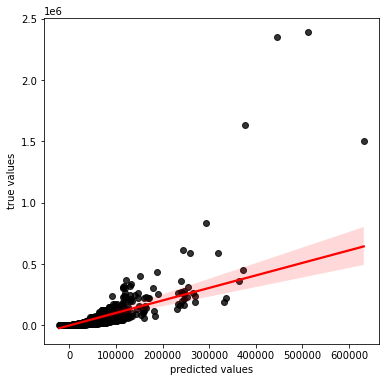

In [300]:
#compare predictions to known values
plt.figure(figsize=(6,6))
ax = sns.regplot(x = y_preds, 
                 y = y_test, 
                 scatter_kws={"color": "black"}, 
                 line_kws={"color": "red"})
ax.set(xlabel='predicted values', ylabel='true values');
#something weird is going on

## Model Evaluation

In [301]:
#root mean sq error
rmse = sqrt(metrics.mean_squared_error(y_test, y_preds))
rmse

21808.183754717873

In [302]:
#is that more or less than if we just used the average as our model?
avg_val = y_train.mean()
avg_val

5964.082332605049

In [303]:
#what would the error be if I predicted the average price for all diamonds?
comparison = np.full((len(y_test), ), avg_val)
comparison[:10]

array([5964.08233261, 5964.08233261, 5964.08233261, 5964.08233261,
       5964.08233261, 5964.08233261, 5964.08233261, 5964.08233261,
       5964.08233261, 5964.08233261])

In [304]:
#compare that to my predictions
y_preds[:10]
#something is very off because the values are negative

array([ -1768.98872225,  -7773.13788229,   1799.40635101,  -3773.22091911,
        36894.12244705,  -2112.93461035, 105839.14026801, -10086.59243056,
          365.35020626,   9010.53486373])

In [305]:
#compare these two:
sqrt(metrics.mean_squared_error(y_test, comparison))

29911.671286357705

In [306]:
# check R-2 (coefficient of determination)
r2 = metrics.r2_score(y_test, y_preds)
round(r2, 2)
#very bad...need to fix something

0.47

## Additional EDA / Cleanup

In [308]:
df['price'].describe()
#why is it like this??
#do I need to remove outliers?

count    1.104580e+05
mean     5.948045e+03
std      3.049067e+04
min      1.447800e+02
25%      7.499050e+02
50%      1.660575e+03
75%      4.798540e+03
max      3.777064e+06
Name: price, dtype: float64

In [309]:
df['color'].describe()
#this one looks normal

count    110458.000000
mean          3.993636
std           2.296074
min           1.000000
25%           2.000000
50%           4.000000
75%           6.000000
max          10.000000
Name: color, dtype: float64

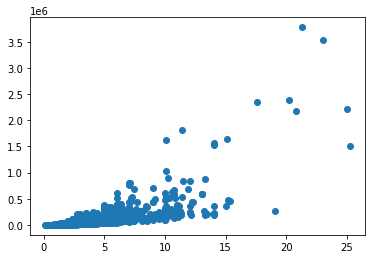

In [312]:
#look at the spread of the data to see if there are outliers
plt.scatter(df['carat'], df['price']);
#there are definitely some outliers probably making it hard to predict well
#not sure how to systematically remove the outliers but I will cut it off at 10 carats for now since most of the data lies below that

In [313]:
df.shape

(110458, 10)

## Remove Outliers and Re-Model

In [316]:
#drop the outliers
df = df[(df["carat"]<10)]

In [317]:
df.shape
#didn't lose much data

(110365, 10)

In [318]:
#try the model again
#declare the target variable
y = df['price']
y.shape

(110365,)

In [319]:
#declare the model features
X = df.drop(['price'], axis=1) #just exclude price
X.shape

(110365, 9)

In [320]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state=12) #using the standard test size for now

In [321]:
#instantiate the SKlearn algorithm
mymodel = LinearRegression(fit_intercept=True, 
                           normalize=False, 
                           copy_X=True, 
                           n_jobs=None, 
                           positive=False)

In [322]:
#fit the model to the training dataset
mymodel.fit(X_train, y_train)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning:

'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.



LinearRegression(normalize=False)

In [323]:
print(mymodel)

LinearRegression(normalize=False)


In [324]:
#what is the intercept?
mymodel.intercept_
#according to my model intercept, if carat, cut, clarity, color, polish, symmetry and the rating agencies were all 0, the diamond would be priced at -$2K
#this looks better than before already!

-1891.4552320532084

In [325]:
#what is the equation for this mymodel?
cols=list(X.columns)
coefs=list(mymodel.coef_)
xcoefs = [(coefs[i], cols[i]) for i in range(0, len(cols))]
output = f'y = {round(mymodel.intercept_,2)} + {round(xcoefs[0][0],2)}*{xcoefs[0][1]} + {round(xcoefs[1][0],2)}*{xcoefs[1][1]} + {round(xcoefs[2][0],2)}*{xcoefs[2][1]} + {round(xcoefs[3][0],2)}*{xcoefs[3][1]} + {round(xcoefs[4][0],2)}*{xcoefs[4][1]} + {round(xcoefs[5][0],2)}*{xcoefs[5][1]} + {round(xcoefs[6][0],2)}*{xcoefs[6][1]}+ {round(xcoefs[7][0],2)}*{xcoefs[7][1]}+ {round(xcoefs[8][0],2)}*{xcoefs[8][1]}'
print("Regression Equation: ", output)

Regression Equation:  y = -1891.46 + 17577.64*carat + -329.89*cut + -945.52*clarity + -935.66*color + -1036.88*Other + 536.86*IGI + 500.02*GIA+ 804.19*polish+ 38.74*symmetry


In [326]:
#for the graph below
coefs=list(mymodel.coef_)
cols=list(X.columns)

In [327]:
#turn these into a dataframe
results = pd.DataFrame(list(zip(cols, coefs)), columns=['feature','coeff'])
results 

,feature,coeff
0,carat,17577.639179
1,cut,-329.892596
2,clarity,-945.520030
3,color,-935.656494
4,Other,-1036.876090
5,IGI,536.856175
6,GIA,500.019915
7,polish,804.190442
8,symmetry,38.735434


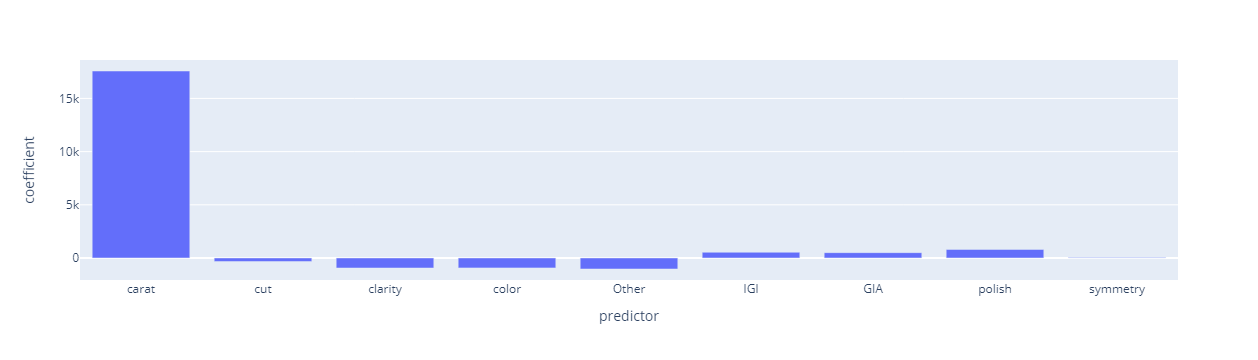

In [328]:
#show results as a bar chart
import plotly.express as px
fig = px.bar(x=results['feature'], y=results['coeff'])
fig.update_layout(
    yaxis=dict( title='coefficient'),
    xaxis=dict( title='predictor'),
)
fig.show()

In [329]:
#predict the y-values on the testing dataset
y_preds = mymodel.predict(X_test)

In [330]:
#compare some of the results of the predictions 
print([round(x,2) for x in y_preds[:5]])
print(list(y_test[:5]))
#still looks wrong...

[2232.65, 233.73, 14331.97, -3010.36, -2050.27]
[1472.33, 2065.8, 6993.81, 838.45, 970.0]


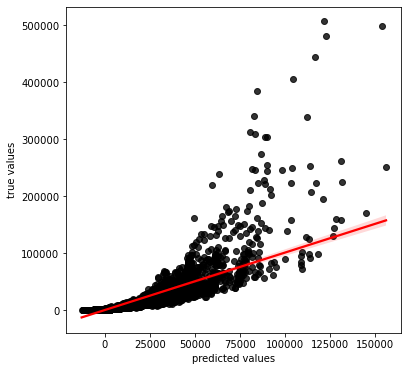

In [331]:
#compare predictions to known values
plt.figure(figsize=(6,6))
ax = sns.regplot(x = y_preds, 
                 y = y_test, 
                 scatter_kws={"color": "black"}, 
                 line_kws={"color": "red"})
ax.set(xlabel='predicted values', ylabel='true values');
#still too much spread

## Model Evaluation v2

In [332]:
# check R-2 (coefficient of determination)
r2 = metrics.r2_score(y_test, y_preds)
round(r2, 2)
#better but probably still need to make the cutoff lower due to high spread in the larger carat ranges

0.63

## Remove Outliers and Re-Model v2

In [335]:
#drop the outliers
df = df[(df["carat"]<2)]
#did a quick check for outliers using IQR in excel; seems like most of the data is below 2 carats which aligns with what I expected

In [336]:
df.shape
#still have over 90% of the original data

(102212, 10)

In [337]:
#try the model again
#declare the target variable
y = df['price']
y.shape

(102212,)

In [338]:
#declare the model features
X = df.drop(['price'], axis=1) #just exclude price
X.shape

(102212, 9)

In [339]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state=12) #using the standard test size for now

In [340]:
#instantiate the SKlearn algorithm
mymodel = LinearRegression(fit_intercept=True, 
                           normalize=False, 
                           copy_X=True, 
                           n_jobs=None, 
                           positive=False)

In [341]:
#fit the model to the training dataset
mymodel.fit(X_train, y_train)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning:

'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.



LinearRegression(normalize=False)

In [342]:
print(mymodel)

LinearRegression(normalize=False)


In [343]:
#what is the intercept?
mymodel.intercept_
#according to my model intercept, if carat, cut, clarity, color, polish, symmetry and the rating agencies were all 0, the diamond would be priced at -$200
#this looks better than before already!

-206.48568263484003

In [344]:
#what is the equation for this mymodel?
cols=list(X.columns)
coefs=list(mymodel.coef_)
xcoefs = [(coefs[i], cols[i]) for i in range(0, len(cols))]
output = f'y = {round(mymodel.intercept_,2)} + {round(xcoefs[0][0],2)}*{xcoefs[0][1]} + {round(xcoefs[1][0],2)}*{xcoefs[1][1]} + {round(xcoefs[2][0],2)}*{xcoefs[2][1]} + {round(xcoefs[3][0],2)}*{xcoefs[3][1]} + {round(xcoefs[4][0],2)}*{xcoefs[4][1]} + {round(xcoefs[5][0],2)}*{xcoefs[5][1]} + {round(xcoefs[6][0],2)}*{xcoefs[6][1]}+ {round(xcoefs[7][0],2)}*{xcoefs[7][1]}+ {round(xcoefs[8][0],2)}*{xcoefs[8][1]}'
print("Regression Equation: ", output)

Regression Equation:  y = -206.49 + 8797.76*carat + -270.84*cut + -281.78*clarity + -310.54*color + -419.5*Other + 164.88*IGI + 254.62*GIA+ 197.41*polish+ -44.3*symmetry


In [345]:
#for the graph below
coefs=list(mymodel.coef_)
cols=list(X.columns)

In [346]:
#turn these into a dataframe
results = pd.DataFrame(list(zip(cols, coefs)), columns=['feature','coeff'])
results 

,feature,coeff
0,carat,8797.757869
1,cut,-270.841058
2,clarity,-281.776828
3,color,-310.538868
4,Other,-419.499582
5,IGI,164.884575
6,GIA,254.615007
7,polish,197.412728
8,symmetry,-44.295248


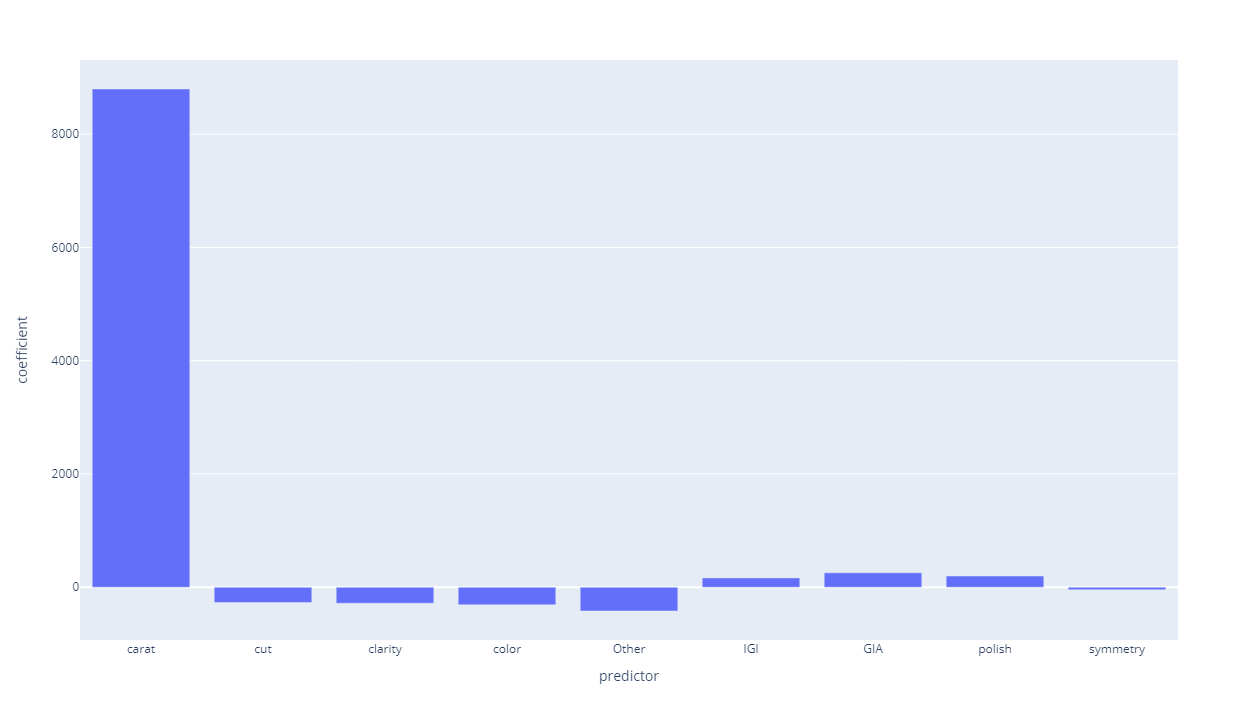

In [347]:
#show results as a bar chart
import plotly.express as px
fig = px.bar(x=results['feature'], y=results['coeff'])
fig.update_layout(
    yaxis=dict( title='coefficient'),
    xaxis=dict( title='predictor'),
)
fig.show()

In [348]:
#predict the y-values on the testing dataset
y_preds = mymodel.predict(X_test)

In [349]:
#compare some of the results of the predictions 
print([round(x,2) for x in y_preds[:5]])
print(list(y_test[:5]))
#much closer!!!

[5085.31, 7015.13, 1910.36, 1786.41, 87.98]
[4525.68, 7091.69, 1102.14, 1152.11, 509.67]


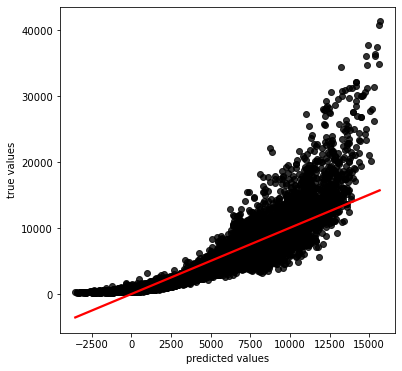

In [350]:
#compare predictions to known values
plt.figure(figsize=(6,6))
ax = sns.regplot(x = y_preds, 
                 y = y_test, 
                 scatter_kws={"color": "black"}, 
                 line_kws={"color": "red"})
ax.set(xlabel='predicted values', ylabel='true values');
#still a lot more spread than I expected

In [351]:
# check R-2 (coefficient of determination)
r2 = metrics.r2_score(y_test, y_preds)
round(r2, 2)
#much better than before but still an interesting curve; seems like for the lower carat ranges, the linear relationship / modeling works well, but in the higher carat ranges, prices diverge more and start to look more parabolic. this makes sense because these sizes are probably much rarer so buyers will have to pay an extra premium above the features I have included in the model

0.81

In [ ]:
#other things I want to try:
#is there a parabolic model?
#or I could split the model even further into different carat ranges...
#have to check if there is enough data for that though

In [ ]:
#add the scatter plots by carat range here